In [20]:
import os
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from util import UnifLabelSampler
from sklearn.metrics import normalized_mutual_info_score

In [21]:
import clus
deepcluster = clus.__dict__["Kmeans"](10)

In [22]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [24]:
print(train_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


In [25]:
# figure = plt.figure(figsize=(10, 8))
# cols, rows = 5, 5
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_data), size=(1,)).item()
#     img, label = train_data[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

In [26]:
#data loader
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1)
    
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1)

In [27]:
true_labels_list = train_data.targets.numpy()

In [28]:
# Define the Convolutional Neural Network model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnt = 1
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5),
                            nn.Linear(32 * 7 * 7, 256),
                            nn.ReLU(inplace=True),
                            nn.Dropout(0.5),
                            nn.Linear(256, 256),
                            nn.ReLU(inplace=True))
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256, 10)
    def forward(self, x):
        if self.cnt:
            print(f'input={x.shape}')
        x = self.conv1(x)
        if self.cnt:
            print(f'first CNN output={x.shape}')
        x = self.conv2(x)
        if self.cnt:
            print(f'second CNN output={x.shape}')
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)    
        if self.cnt:
            print(f'flatten output={x.shape}')
        x = self.fc1(x)  
        if self.cnt:
            print(f'fc1={x.shape}')
        if self.out:
            x = self.out(x)
        
        if self.cnt:
            print(f'output layer output={x.shape}')
            self.cnt = 0
        return  x    # return x for visualization

In [29]:
cnn = CNN()
cnn.out=None
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1568, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
  )
  (out): None
)


In [30]:
#loss function
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [31]:
# optimizer
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [32]:
def compute_features(dataloader, N):
    cnn.eval()
    for i, (images, labels) in enumerate(dataloader):
        b_x = Variable(images)   # batch x
        with torch.no_grad():
            aux = cnn(b_x)
        aux = aux.cpu().numpy()
  
        if i == 0:
            features = np.zeros((N, aux.shape[1]), dtype='float32')

        aux = aux.astype('float32')
        if i < len(dataloader) - 1:
            features[i * batch_size: (i + 1) * batch_size] = aux
        else:
            # special treatment for final batch
            features[i * batch_size:] = aux
    return features

In [33]:
class ReassignedDataset():
    """A dataset where the new images labels are given in argument.
    Args:
        image_indexes (list): list of data indexes
        pseudolabels (list): list of labels for each data
        dataset (list): list of tuples with paths to images
        transform (callable, optional): a function/transform that takes in
                                        an PIL image and returns a
                                        transformed version
    """

    def __init__(self, image_indexes, pseudolabels, dataset, transform=None):
        self.imgs = self.make_dataset(image_indexes, pseudolabels, dataset)
        self.transform = transform

    def make_dataset(self,image_indexes, pseudolabels, dataset):
        label_to_idx = {label: idx for idx, label in enumerate(set(pseudolabels))}
        images = []
        for j, idx in enumerate(image_indexes):
            img, _ = dataset[idx]  # Retrieve the image from the dataset
            pseudolabel = label_to_idx[pseudolabels[j]]
            images.append((img, pseudolabel))
        return images

    def __getitem__(self, index):
        """
        Args:
            index (int): index of data
        Returns:
            tuple: (image, pseudolabel) where pseudolabel is the cluster of the index datapoint
        """
        img, pseudolabel = self.imgs[index]
        # img is already a tensor, so no need to load it with pil_loader
        if self.transform is not None:
            img = self.transform(img)
        return img, pseudolabel


    def __len__(self):
        return len(self.imgs)


In [34]:
def cluster_assign(images_lists, dataset):
    """Creates a dataset from clustering, with clusters as labels.
    Args:
        images_lists (list of list): for each cluster, the list of image indexes
                                    belonging to this cluster
        dataset (list): initial dataset
    Returns:
        ReassignedDataset(torch.utils.data.Dataset): a dataset with clusters as
                                                     labels
    """
    assert images_lists is not None
    pseudolabels = []
    image_indexes = []
    for cluster, images in enumerate(images_lists):
        image_indexes.extend(images)
        pseudolabels.extend([cluster] * len(images))
    return ReassignedDataset(image_indexes, pseudolabels, dataset, None)

In [35]:
def per_epoch(epochs, num_epochs, cnn, loader, train):

    if train:
        cnn.train()
        optimizer_tl = torch.optim.SGD(cnn.out.parameters(),lr=0.01, weight_decay=10**-5)
    else:
        cnn.eval()
        
    # Train the model
    total_step = len(loader)
    #print(total_step)
    total_loss = 0.0
    total_acc = 0.0
        
    for i, (images, labels) in enumerate(loader):
        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y
        output = cnn(b_x) 
        print(output.shape)
        loss = loss_func(output, b_y)
        total_loss+= loss.item()
        pred_y = torch.max(output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        total_acc += accuracy
        if train:
            # clear gradients for this training step   
            optimizer.zero_grad()
            optimizer_tl.zero_grad()
        
            # backpropagation, compute gradients 
            loss.backward()
            #for name, param in cnn.named_parameters():
                #if param.grad is not None:
                    #print(f'Gradient of {name}: {param.grad.abs().mean().item()}')
            # apply gradients             
            optimizer.step() 
            optimizer_tl.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Acc: {:.4f} ' 
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy))
    return (total_loss/total_step), (total_acc/total_step)

In [36]:
tr_loss_epoch,  val_loss_epoch,  tr_acc_epoch,  val_acc_epoch = [], [], [], []
nmi_list1=[]
nmi_list=[]
prev_assignments = None
num_epochs = 100
least_loss = 9999
logdir='mnist_output'
print(logdir)
# Create the output folder
try:
    os.stat(logdir)
except:
    os.makedirs(logdir)

for epoch in range(0, num_epochs):
    cnn.out=None
    train_features = compute_features(train_loader, len(train_data))
    print(train_features.shape)
    test_features=compute_features(test_loader, len(test_data))
    # cluster the feature
    clustering_loss = deepcluster.cluster(train_features,test_features, verbose=False)
    
    # assign pseudo-labels
    train_dataset = cluster_assign(deepcluster.images_lists, train_data)
   
    # uniformly sample per target
    sampler = UnifLabelSampler(int(1 * len(train_dataset)), deepcluster.images_lists)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=1,
        sampler=sampler,
        pin_memory=True,
    )
   
    # assign pseudo-labels
    test_dataset = cluster_assign(deepcluster.images_lists1, test_data)

    sampler = UnifLabelSampler(int(1 * len(test_dataset)), deepcluster.images_lists1)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=1,
        sampler=sampler,
        pin_memory=True,
    )
    cnn.out= nn.Linear(256, 10)
    
    tr_loss, tr_acc = per_epoch(epoch, num_epochs, cnn, train_dataloader, train=True)
    tr_loss_epoch.append(tr_loss), tr_acc_epoch.append(tr_acc)
    val_loss, val_acc = per_epoch(epoch, num_epochs, cnn, test_dataloader, train=False)
    val_loss_epoch.append(val_loss), val_acc_epoch.append(val_acc)
    print ('Epoch {}, Train Loss: {:.4f} train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f} ' 
                   .format(epoch, tr_loss, tr_acc, val_loss, val_acc))

    train_file = open(logdir + '/train_log.txt',"a")
    train_file.write("Epoch {}: train: [loss-{:.6f} error-{:.6f} ], val: [loss-{:.6f} error-{:.6f}]\n".                 
              format(epoch, tr_loss, tr_acc, val_loss, val_acc))
    train_file.close()

    if val_loss < least_loss:
        min_loss_epoch = epoch
        torch.save(cnn.state_dict(), logdir+'/best_loss_model.pth')
        least_loss = val_loss 

    current_assignments = np.zeros(len(train_data))
    for cluster_id, indices in enumerate(deepcluster.images_lists):
        for index in indices:
            current_assignments[index] = cluster_id

    # Calculate NMI between true labels and current assignments
    nmi1 = normalized_mutual_info_score(true_labels_list, current_assignments)
    nmi_list1.append(nmi1)
    print(f'Epoch {epoch}, NMI 2 {nmi1}')

    # Calculate NMI if there is a previous assignment
    if prev_assignments is not None:
        nmi = normalized_mutual_info_score(prev_assignments, current_assignments)
        nmi_list.append(nmi)
        print(f'Epoch {epoch}, NMI {nmi}')

    train_file = open(logdir + '/train_log.txt',"a")
    train_file.write("NMI between true labels and current assignments {}\n".format(nmi1))
    if prev_assignments is not None:
        train_file.write("NMI between previous and current assignments {}\n".format(nmi))
    train_file.close()
    
    # Update previous assignments
    prev_assignments = current_assignments

mnist_output
input=torch.Size([100, 1, 28, 28])
first CNN output=torch.Size([100, 16, 14, 14])
second CNN output=torch.Size([100, 32, 7, 7])
flatten output=torch.Size([100, 1568])
fc1=torch.Size([100, 256])
output layer output=torch.Size([100, 256])
(60000, 256)
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size(

KeyboardInterrupt: 

In [18]:

            print("=> loading checkpoint ")
            checkpoint = torch.load('mnist_output/best_loss_model.pth')

            # remove top_layer parameters from checkpoint
            for keys in checkpoint:
                print(keys)
           
            print(checkpoint['fc1.1.weight'] )
           
            print("=> loaded checkpoint  (epoch {})"
                  .format( checkpoint['epoch']))
        
          

=> loading checkpoint 
conv1.0.weight
conv1.0.bias
conv2.0.weight
conv2.0.bias
fc1.1.weight
fc1.1.bias
fc1.4.weight
fc1.4.bias
out.weight
out.bias
tensor([[ 0.0240,  0.0040, -0.0106,  ...,  0.0192, -0.0289,  0.0162],
        [-0.0283,  0.2479,  0.2371,  ...,  0.2811,  0.4298,  0.1400],
        [-0.0115, -0.0112, -0.0065,  ...,  0.0228,  0.0526, -0.0130],
        ...,
        [ 0.0029,  0.0019, -0.0168,  ..., -0.0423,  0.0058,  0.0197],
        [ 0.0166,  0.2821,  0.4272,  ..., -0.2109,  0.1436,  0.3035],
        [ 0.0668,  0.3388,  0.3634,  ...,  0.2354,  0.3386,  0.1824]])


KeyError: 'epoch'

In [ ]:
# tr_loss_epoch,  val_loss_epoch,  tr_acc_epoch,  val_acc_epoch = [], [], [], []
# num_epochs = 10
# for epoch in range(num_epochs):
#     tr_loss, tr_acc = per_epoch(epoch, num_epochs, cnn, train_loader, train=True)
#     tr_loss_epoch.append(tr_loss), tr_acc_epoch.append(tr_acc)
#     val_loss, val_acc = per_epoch(epoch, num_epochs, cnn, test_loader, train=False)
#     val_loss_epoch.append(val_loss), val_acc_epoch.append(val_acc)
#     print ('Epoch {}, Train Loss: {:.4f} train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f} ' 
#                    .format(epoch, tr_loss, tr_acc, val_loss, val_acc))

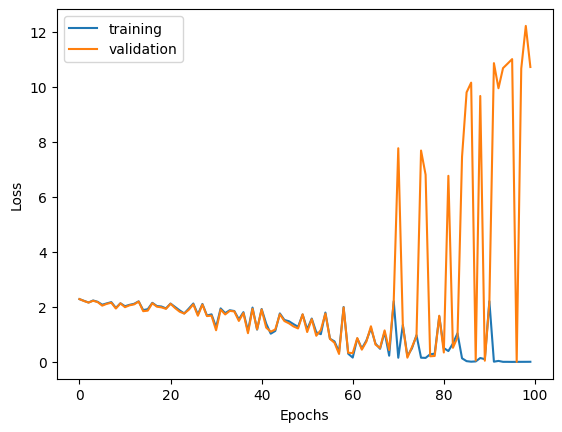

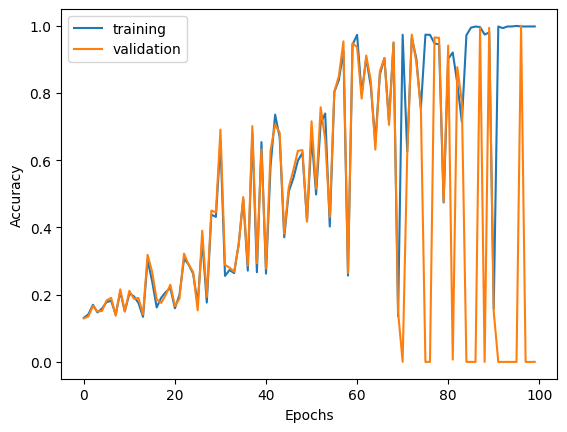

In [19]:
plt.figure()
plt.plot(tr_loss_epoch, label='training')
plt.plot(val_loss_epoch, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(logdir + "/loss.png")

plt.figure()
plt.plot(tr_acc_epoch, label='training')
plt.plot(val_acc_epoch, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(logdir + "/acc.png")

In [ ]:
# Plot NMI over epochs
plt.figure()
plt.plot(nmi_list, label='NMI over epochs')
plt.xlabel('Epoch')
plt.ylabel('NMI')
plt.title('NMI Stability Over Time')
plt.legend()
plt.show()

# Plot NMI over epochs
plt.figure()
plt.plot(nmi_list1, label='NMI over epochs')
plt.xlabel('Epoch')
plt.ylabel('NMI')
plt.title('NMI between true labels and cluster assignments over epochs')
plt.legend()
plt.show()

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    return accuracy

In [ ]:
accuracy = test()
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)